# **Goal**


The goal is to perform funnel analysis for an e-commerce website.

Typically, websites have a clear path to conversion: for instance, you land on the home page, then you search, select a product, and buy it. At each of these steps, some users will drop off and leave the site. The sequence of pages that lead to conversion is called 'funnel'.
Data Science can have a tremendous impact on funnel optimization. Funnel analysis allows to understand where/when our users abandon the website. It gives crucial insights on user behavior and on ways to improve the user experience. Also, it often allows to discover bugs.

# **Challenge**

You are looking at data from an e-commerce website. The site is very simple and has just 4 pages:

The first page is the home page. When you come to the site 
for the first time, you can only land on the home page as a first page.

From the home page, the user can perform a search and land on the search page. 

From the search page, if the user clicks on a product, she will get to the payment page,
where she is asked to provide payment information in order to buy that product.

If she does decide to buy, she ends up on the confirmation page.

The company CEO isn't very happy with the volume of sales and, especially, of sales coming from new users. Therefore, she asked you to investigate whether there is something wrong in the conversion funnel or, in general, if you could suggest how conversion rate can be improved.

Specifically, she is interested in :

1. A full picture of funnel conversion rate for both desktop and mobile.
2. Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [214]:
user = pd.read_csv("user_table.csv")
home = pd.read_csv("home_page_table.csv")
search = pd.read_csv("search_page_table.csv")
payment = pd.read_csv("payment_page_table.csv")
confirm = pd.read_csv("payment_confirmation_table.csv")

In [215]:
data = pd.merge(left=user, right=home, how='left', on='user_id')
data = pd.merge(left=data, right=search, how='left', on='user_id', suffixes=('_home', '_search'))
data = pd.merge(left=data, right=payment, how='left', on='user_id')
data = pd.merge(left=data, right=confirm, how='left', on='user_id', suffixes=('_payment', '_confirmation'))
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [216]:
# date transformation
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['week'] = pd.DatetimeIndex(data['date']).week
data['dayofweek'] = pd.DatetimeIndex(data['date']).dayofweek
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation,year,month,day,week,dayofweek
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN,2015,2,28,9,5
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN,2015,1,13,3,1
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN,2015,4,9,15,3
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN,2015,2,18,8,2
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN,2015,1,15,3,3


In [217]:
data['step'] = 'home'
data.loc[data['page_confirmation'].notnull(), 'step'] = 'confirmation'
data.loc[((data['page_confirmation'].isnull()) & (data['page_payment'].notnull())), 'step'] = 'payment'
data.loc[((data['page_confirmation'].isnull()) & (data['page_payment'].isnull()) & (data['page_search'].notnull())), 'step'] = 'search'
#rename colmuns
data = data.rename(columns={'page_home':'funnel1', 'page_search':'funnel2', 'page_payment':'funnel3', 'page_confirmation':'funnel4'})

In [218]:
# conversion rate of each step: users of each step/total users
for i in ['funnel1', 'funnel2', 'funnel3', 'funnel4']:
  print(i, data[i].count()/data.user_id.count())

funnel1 1.0
funnel2 0.5
funnel3 0.06670353982300885
funnel4 0.005


## **Device**

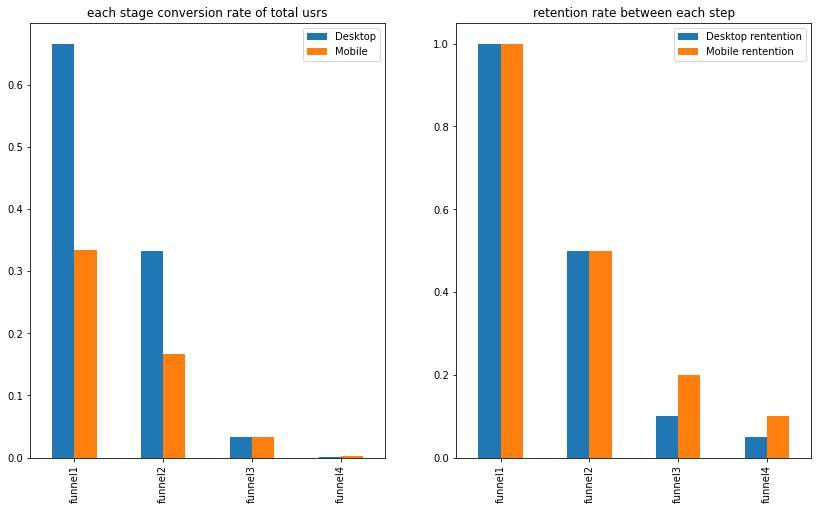

In [219]:
# total conversion rate group by device
funnel_device = pd.DataFrame()
for type in data['device'].unique():
  funnel_device[type] = data[data.device == type][['funnel1','funnel2','funnel3','funnel4']].count()/data.user_id.count()

# retention rate: conversion rate between each funnel group by device
device_visit = pd.DataFrame()
for type in data['device'].unique():
  device_visit[type] = data[data.device == type][['funnel1','funnel2','funnel3','funnel4']].count()
device_visit['Desktop diff'] = device_visit['Desktop'].diff(1)
device_visit['Desktop rentention'] = round(device_visit['Desktop']/(device_visit['Desktop']+abs(device_visit['Desktop diff'])),2)
device_visit['Mobile diff'] = device_visit['Mobile'].diff(1)
device_visit['Mobile rentention'] = round(device_visit['Mobile']/(device_visit['Mobile']+abs(device_visit['Mobile diff'])),2)
device_visit = device_visit.drop(columns=['Desktop', 'Mobile', 'Desktop diff', 'Mobile diff'])
device_visit = device_visit.fillna(1)
device_visit

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
funnel_device.plot(kind='bar', ax=axes[0], title="each stage conversion rate of total usrs")
device_visit.plot(kind='bar',ax=axes[1], title="retention rate between each step")

Desktop users has doubled homepages visits, but mobile users has a better conversion rate.

Mobile and Desktop users have similar retention rate through the first two funnels. However, mobile users has almost doubled retention rate in the later funnels: from search page to payment page and from payment page to payment confirm page.

## **Sex**

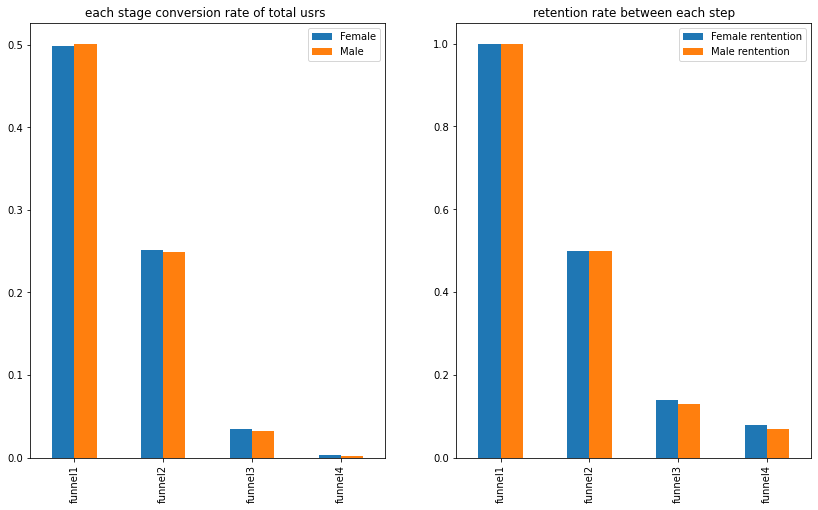

In [220]:
# total conversion rate group by sex
funnel_sex = pd.DataFrame()
for type in data['sex'].unique():
  funnel_sex[type] = data[data.sex == type][['funnel1','funnel2','funnel3','funnel4']].count()/data.user_id.count()

# retention rate: conversion rate between each funnel group by sex
sex_visit = pd.DataFrame()
for type in data['sex'].unique():
  sex_visit[type] = data[data.sex == type][['funnel1','funnel2','funnel3','funnel4']].count()
sex_visit['Female diff'] = sex_visit['Female'].diff(1)
sex_visit['Female rentention'] = round(sex_visit['Female']/(sex_visit['Female']+abs(sex_visit['Female diff'])),2)
sex_visit['Male diff'] = sex_visit['Male'].diff(1)
sex_visit['Male rentention'] = round(sex_visit['Male']/(sex_visit['Male']+abs(sex_visit['Male diff'])),2)
sex_visit = sex_visit.drop(columns=['Female', 'Male', 'Female diff', 'Male diff'])
sex_visit = sex_visit.fillna(1)
sex_visit

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
funnel_sex.plot(kind='bar', ax=axes[0], title="each stage conversion rate of total usrs ")
sex_visit.plot(kind='bar',ax=axes[1], title="retention rate between each step")

Not much differnece between different sex group in conversion rate and retention rate.

## **Date**

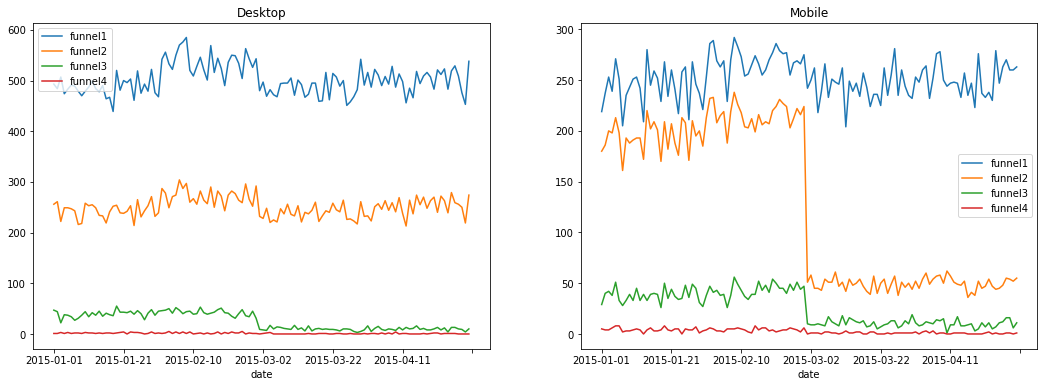

In [221]:
#page visits
data_desktop = data.query('device=="Desktop"')
data_mobile = data.query('device=="Mobile"')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
data_desktop.groupby('date')[['funnel1', 'funnel2', 'funnel3', 'funnel4']].count().plot(ax=axes[0], title='Desktop')
data_mobile.groupby('date')[['funnel1', 'funnel2', 'funnel3', 'funnel4']].count().plot(ax=axes[1], title='Mobile')

Surprisingly, there was a big problem on conversion at Mobile from search page to payment page. Possible reasons could be website layout update, tracking error and engineering testing.

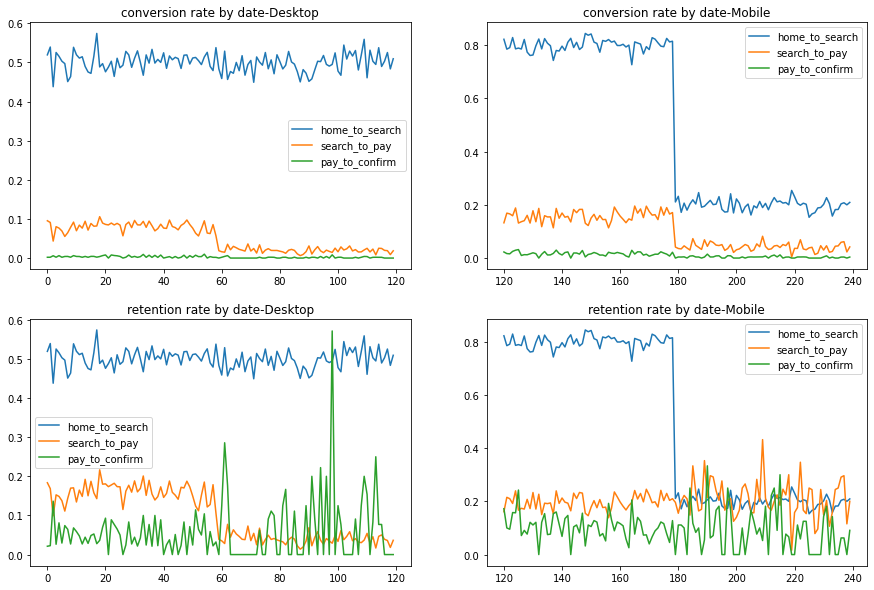

In [222]:
# conversion rate
conversion_time = pd.DataFrame()
date_groupby = data.groupby(['device','date'],as_index=False).count()
conversion_time['device'] = date_groupby['device']
conversion_time['date'] = date_groupby['date']
conversion_time['home_to_search'] = date_groupby['funnel2']/date_groupby['funnel1']
conversion_time['search_to_pay'] = date_groupby['funnel3']/date_groupby['funnel1']
conversion_time['pay_to_confirm'] = date_groupby['funnel4']/date_groupby['funnel1']

# retention rate
retention_time = pd.DataFrame()
date_groupby = data.groupby(['device','date'],as_index=False).count()
retention_time['device'] = date_groupby['device']
retention_time['date'] = date_groupby['date']
retention_time['home_to_search'] = date_groupby['funnel2']/date_groupby['funnel1']
retention_time['search_to_pay'] = date_groupby['funnel3']/date_groupby['funnel2']
retention_time['pay_to_confirm'] = date_groupby['funnel4']/date_groupby['funnel3']
retention_time

# plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
conversion_time.query('device=="Desktop"').plot(ax=axes[0,0], title='conversion rate by date-Desktop')
conversion_time.query('device=="Mobile"').plot(ax=axes[0,1], title='conversion rate by date-Mobile')
retention_time.query('device=="Desktop"').plot(ax=axes[1,0], title='retention rate by date-Desktop')
retention_time.query('device=="Mobile"').plot(ax=axes[1,1], title='retention rate by date-Mobile')


## **Conclusion**

1 Desktop has more users than mobile , but much lower conversion rate (1% vs 0.2%). Having less mobile visitors is pretty worrisome. Pretty much all healthy tech companies should have more mobile users than desktop. So growing mobile should be a top priority for the company as a whole

2 There are a couple of ways to explain the lower conversion rate on desktop:
*  Product: desktop has a worse product. So product team should look into the differences between the two to see if UX/UI can be improved on desktop
*  Marketing: the two platforms are attracting different kinds of users. So they just act as a proxy for user distribution. For instance, mobile didn’t get popular and only has power users, who obviously convert at a much higher rate. Or desktop is spending a lot on ads and these ads are attracting lower intent users. If we had more data about the users, we could find out if user distribution is the same across the devices (so it is most likely a product problem) or not (-> marketing problem). The marketing explanation has the advantage of explaining also the strangely lower absolute count for mobile users

3 All key metrics for both devices have actually gone down a lot in the last few months. All drops though appear to happen on specific days and one specific pages. This kind of behavior is often the sign of a bug (more likely) or bad product changes (which at the end of the day are basically bugs too, just product bugs instead of engineering bugs). Usual analysis steps to find out why a metric suddenly dropped should be done here.

4 It is hard to say without more information about the site, but the funnel numbers across the board don’t look particularly good. For instance, even before the bug, only at most 20% of users go from the search page to the payment page. These are clearly users with some sort of intent. It could be interesting to look into the characteristics of the search queries to see if people are constantly looking for something they cannot find. Essentially, trying to understand lack of supply compared to user demand.

For the funnel conversion, there must have something happen on 2015-03-01, which result in higher leakage for search page on Mobile and for payment page on Desktop. Need to coordinate with engineer team to find the reason, is it a bug, or website layout change, or competitors steal the traffic.